In [29]:
using Pkg; Pkg.activate("..")
using Revise
using GraphFusedLasso
using Distributions
using Random
using RCall

In [47]:
R"library('tidyverse')"
R"library(latex2exp)"

RObject{StrSxp}
 [1] "latex2exp" "forcats"   "stringr"   "dplyr"     "purrr"     "readr"    
 [7] "tidyr"     "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics" 
[13] "grDevices" "utils"     "datasets"  "methods"   "base"     


In [31]:
Random.seed!(809895);

In [32]:
# data generation

N = 150

x1 = collect(1:(N ÷ 3))
x2 = collect((N ÷ 3 + 1):(2(N ÷ 3)))
x3 = collect((2(N ÷ 3) + 1):N)
x = [x1; x2; x3]
y1 = fill(-1., length(x1))
y2 = fill(0.75, length(x2))
y3 = 0.75 .- 2.5 .* (x3 .- length(x2)) ./ (N - length(x2))
μ1 = [y1; y2; y3]
μ2 = 0.25 .* μ1 .+ 1.5

σ = 0.25

evalpts = collect(range(-3.0, 3.0, length=100))
densities = [MixtureModel([Normal(μ1[i], σ), Normal(μ2[i], σ)])
             for i in 1:N]
# densities = [Normal(μ1[i], σ) for i in 1:N]
devals = [pdf.(d, evalpts) for d in densities];
ndata = [rand([0, 10]) for d in densities]

ndata[1] = 10

for i in 40:60
    ndata[i] = 0
end

for i in 90:110
    ndata[i] = 0
end

ndata[150] = 10

println("missingess: ", sum([1 for n in ndata if n == 0])/N)

y = [rand(d, n) for (d, n) in zip(densities, ndata)]

missingess: 0.66


150-element Array{Array{Float64,1},1}:
 [0.830643, 1.41122, -0.631256, -1.17013, 1.11931, 1.44811, -1.16537, 1.36493, -1.37351, -0.889378]   
 [-0.9239, 1.46946, 1.48733, 0.997715, -1.11589, -0.564786, -0.998489, 1.61154, -0.952999, -0.90749]  
 [-0.877332, 1.1713, 1.04594, 1.31403, 1.09472, -0.843732, 1.12705, 1.33461, -1.27758, -0.649094]     
 []                                                                                                   
 [1.70299, -1.19696, 1.26304, 1.26322, -0.702076, 0.978018, 1.24269, 1.66539, 1.5965, 0.950432]       
 [1.15521, 0.842232, 1.39406, -1.21641, -1.13663, -0.846825, 1.54667, 1.49432, 0.95089, 1.30134]      
 []                                                                                                   
 []                                                                                                   
 [-1.11228, 1.52787, 0.954988, 1.34968, -0.778433, -0.740804, -0.929092, 1.53063, -0.768206, -1.34782]
 [1.23757, -1.13868, 1.28608, 0.99

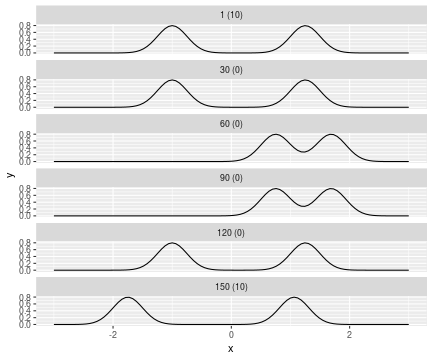

RObject{VecSxp}


In [33]:
nplots = 36
stepsize = N ÷ nplots
xs = Float64[]
plt = Float64[]
vals = Float64[]

# for i in 1:nplots
#     append!(xs, evalpts)
#     append!(plt, fill((i - 1) * stepsize + 1, length(evalpts)))
#     append!(vals, devals[(i - 1) * stepsize + 1])
# end

for i in [1, 30, 60, 90, 120, 150]
    append!(xs, evalpts)
    append!(plt, fill(i, length(evalpts)))
    append!(vals, devals[i])
end

R"""
df = data.frame(x=$xs, plt=$plt, y=$vals)

nd = $ndata
my_labeller = function(t) {
    return (sprintf("%s (%s)", t, nd[as.integer(t)]))
}

ggplot(df, aes(x=x, y=y)) +
    geom_line() +
    facet_wrap(. ~ plt, ncol=1, labeller = labeller("plt"=my_labeller)) +
    ggsave("densities.png", units="cm", width=18, height=14)
"""

In [34]:
# function for cross-validation fit

function generate_cvsets(y, nsplits)
    # make the cv splits
    N = length(y)
    cvsets = [Set{Int}() for i in 1:nsplits]
    iobs = shuffle([i for (i, yi) in enumerate(y) if !isempty(yi)])
    Nobs = length(iobs)
    splitsize = Nobs ÷ nsplits
    for k in 1:nsplits
        for i in ((k - 1) * splitsize + 1):(k * splitsize)
            push!(cvsets[k], iobs[i])
        end
    end
    return cvsets
end
               
                
function fit(ytrain, λ1, λ2)
    N = length(ytrain)
    lambdasl1 = fill(λ1, N)
    lambdasl2 = fill(λ2, N)

    # create the tree
    M  = 33
    splits = collect(range(-2.5, 2.5, length=M))
    tree = DensityTree(splits)
    bins2counts = Dict()
    for (j, (li, ui)) in enumerate([tree.bins; [(i, i+1) for i in 1:M-1]])
        lower = splits[li]
        upper = splits[ui]
        k = [sum(lower .< yi .< upper) for yi in ytrain]
        bins2counts[(li, ui)] = k
    end
            
    # fit binomial model in each tree
    beta = zeros(N, M - 2)
    for j in 1:M - 2
        li, ui = tree.bins[j]
        mi = (ui + li) ÷ 2 
        parent_counts = bins2counts[(li, ui)] .+ 0.1
        left_counts = bins2counts[(li, mi)]  .+ 0.05

        lambdasl1 = fill(λ1, N)
        lambdasl2 = fill(λ2, N)
        model = BinomialEnet(
            ptr, brks, lambdasl1, lambdasl2;
            abstol=0.0, reltol=1e-7)
        fit!(model, left_counts, parent_counts; steps=3000)

        beta[:, j] = model.beta
    end
    tree.beta = beta
    return tree
end

                
function cv_fit(y, evalpts, ptr, brks, lambdas, cvsets)
    # for each cv split get the mse error
    N = length(y)
    nsplits = length(cvsets)
    nlambdas = length(lambdas)
    test_likelihood = zeros(nlambdas)
                    
    # prepare the tree structure and the bint 
    for (k, (λ1, λ2)) in enumerate(lambdas)
        for i in 1:nsplits
            # get the cv vector with missing data
            ytrain = [j in cvsets[i] ? Float64[] : yi
                      for (j, yi) in enumerate(y)]

            tree = fit(ytrain, λ1, λ2)               
                            
            # compute the out-of-sample likelihood
            Ntest = 0.0
            likelihood = 0.0
            for j in collect(cvsets[i])
                test_eval = y[j]
                Ntest += length(test_eval)
                likelihood += sum(predict(tree, sort(test_eval))[j])
            end
            likelihood /= Ntest
                             
            test_likelihood[k] += likelihood / nsplits
        end
    end

    # now choose the best lambdas
    best_lambdas = lambdas[argmax(test_likelihood)]
    best_likelihood = maximum(test_likelihood)

    # train best for mse
    best_tree = fit(y, best_lambdas[1], best_lambdas[2])
    densities = predict(best_tree, evalpts)


    return Dict("best_lambdas" => best_lambdas,
                "best_likelihood" => best_likelihood,
                "densities" => densities,
                "cvsets" => cvsets)
end

cv_fit (generic function with 1 method)

In [35]:
nsplits = 5
ptr = collect(1:N)
brks = [1, N + 1]
cvsets = generate_cvsets(y, nsplits)

5-element Array{Set{Int64},1}:
 Set([21, 12, 134, 3, 64, 36, 62, 22, 138, 24])   
 Set([71, 133, 68, 26, 10, 80, 61, 137, 149, 139])
 Set([128, 37, 119, 9, 125, 122, 130, 131, 82, 6])
 Set([73, 132, 1, 31, 77, 140, 145, 78, 141, 18]) 
 Set([33, 2, 114, 19, 87, 70, 5, 150, 142, 85])   

Dict{String,Any} with 4 entries:
  "cvsets"          => Set{Int64}[Set([21, 12, 134, 3, 64, 36, 62, 22, 138, 24]…
  "best_lambdas"    => (2.08163, 1.0e-12)
  "densities"       => Array{Float64,1}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0…
  "best_likelihood" => 0.443614

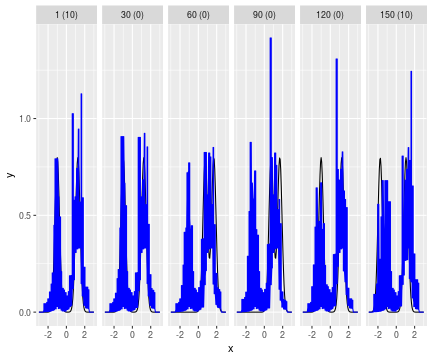

RObject{VecSxp}


In [36]:
# compute the fused lasso best
lambdas = [(l, 1e-12) for l in range(1e-12, 3.0, length=50)]
results_fl = cv_fit(y, evalpts, ptr, brks, lambdas, cvsets)

devals_fl = results_fl["densities"]

display(results_fl)

nplots = 36
stepsize = N ÷ nplots
vals_fl = Float64[]
for i in 1:nplots
    append!(vals_fl, devals_fl[i * stepsize])
end


R"""
df = data.frame(x=$xs, plt=$plt, y=$vals)
df_fl = data.frame(x=$xs, plt=$plt, y=$vals_fl)
    
nd = $ndata
my_labeller = function(t) {
    return (sprintf("%s (%s)", t, nd[as.integer(t)]))
}
    
ggplot() +
    geom_line(data=df, aes(x=x, y=y)) +
    geom_line(data=df_fl, aes(x=x, y=y), col="blue") +
    facet_wrap(. ~ plt, ncol=sqrt($nplots), labeller = labeller("plt"=my_labeller)) +
    ggsave("densities_fl.png", units="cm", width=18, height=14)
"""

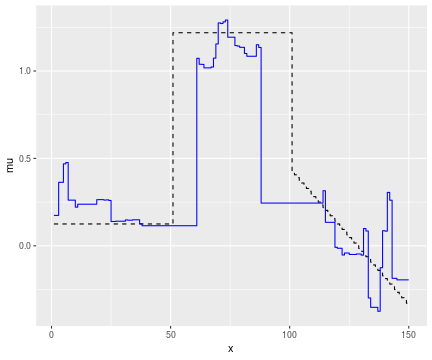

RObject{VecSxp}


In [37]:
nplots = 36
δ = evalpts[2] - evalpts[1]
means_fl = Float64[]
for i in 1:N
    f = devals_fl[i] .* evalpts
    μhat = δ .* (0.5f[1] + 0.5f[2] + sum(f[2:end - 1]))
    push!(means_fl, μhat)
end

m = 0.5*μ1 + 0.5*μ2
R"""
df = data.frame(x=$(1:N), y=$means_fl, mu=$m)
ggplot() +
    geom_step(data=df, aes(x=x, y=mu), linetype="dashed") +
    geom_step(data=df, aes(x=x, y=y), col="blue")
"""

In [38]:
# compute the fused lasso best
lambdas = [(1e-12, l) for l in range(1e-12, 30.0, length=100)]
results_kal = cv_fit(y, evalpts, ptr, brks, lambdas, cvsets)

devals_kal = results_kal["densities"]

display(results_kal)

nplots = 36
stepsize = N ÷ nplots
vals_kal = Float64[]
for i in 1:nplots
    append!(vals_kal, devals_kal[i * stepsize])
end



Dict{String,Any} with 4 entries:
  "cvsets"          => Set{Int64}[Set([21, 12, 134, 3, 64, 36, 62, 22, 138, 24]…
  "best_lambdas"    => (1.0e-12, 9.39394)
  "densities"       => Array{Float64,1}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0…
  "best_likelihood" => 0.482917

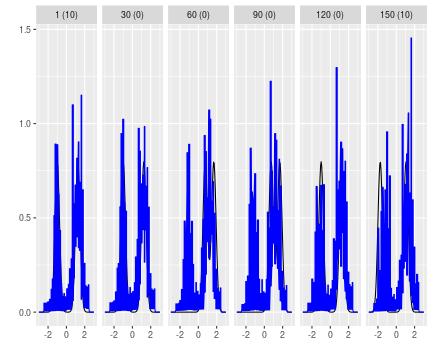

RObject{VecSxp}


In [39]:
R"""
df = data.frame(x=$xs, plt=$plt, y=$vals)
df_kal = data.frame(x=$xs, plt=$plt, y=$vals_kal)

nd = $ndata
my_labeller = function(t) {
    return (sprintf("%s (%s)", t, nd[as.integer(t)]))
}

ggplot() +
    geom_line(data=df, aes(x=x, y=y), size=0.5) +
    geom_line(data=df_kal, aes(x=x, y=y), col="blue", size=0.5) +
    facet_wrap(. ~ plt, ncol=12, labeller = labeller("plt"=my_labeller)) +
    labs(x="", y="") +
    ggsave("benchmarks_densities_kal.png", units="cm", width=25, height=7)
"""

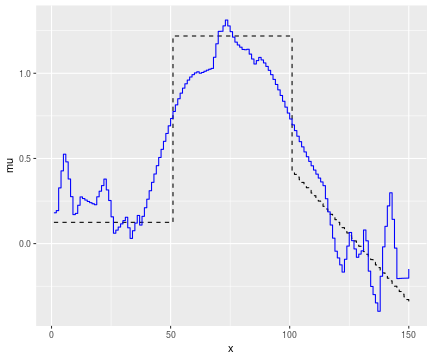

RObject{VecSxp}


In [40]:
nplots = 36
δ = evalpts[2] - evalpts[1]
means_kal = Float64[]
for i in 1:N
    f = devals_kal[i] .* evalpts
    μhat = δ .* (0.5f[1] + 0.5f[2] + sum(f[2:end - 1]))
    push!(means_kal, μhat)
end

m = 0.5*μ1 + 0.5*μ2
R"""
df = data.frame(x=$(1:N), y=$means_kal, mu=$m)
ggplot() +
    geom_step(data=df, aes(x=x, y=mu), linetype="dashed") +
    geom_step(data=df, aes(x=x, y=y), col="blue")
"""

In [41]:
# compute the fused lasso best
lambdas = [(l1, l2) for l1 in range(1.0, 2.0, length=15)
                    for l2 in range(1e-12, 5.0, length=15)]
results_enet = cv_fit(y, evalpts, ptr, brks, lambdas, cvsets)

devals_enet = results_enet["densities"]

display(results_enet)

nplots = 36
stepsize = N ÷ nplots
vals_enet = Float64[]
for i in 1:nplots
    append!(vals_enet, devals_enet[i * stepsize])
end



Dict{String,Any} with 4 entries:
  "cvsets"          => Set{Int64}[Set([21, 12, 134, 3, 64, 36, 62, 22, 138, 24]…
  "best_lambdas"    => (1.0, 5.0)
  "densities"       => Array{Float64,1}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0…
  "best_likelihood" => 0.473376

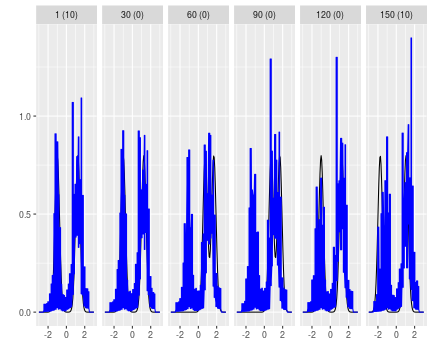

RObject{VecSxp}


In [42]:

R"""
df = data.frame(x=$xs, plt=$plt, y=$vals)
df_enet = data.frame(x=$xs, plt=$plt, y=$vals_enet)
            
nd = $ndata
my_labeller = function(t) {
    return (sprintf("%s (%s)", t, nd[as.integer(t)]))
}

ggplot() +
    geom_line(data=df, aes(x=x, y=y), size=0.5) +
    geom_line(data=df_enet, aes(x=x, y=y), col="blue", size=0.5) +
    facet_wrap(. ~ plt, ncol=12, labeller = labeller("plt"=my_labeller)) +
    labs(x="", y="") +
    ggsave("benchmarks_densities_enet.png", units="cm", width=25, height=7)
"""

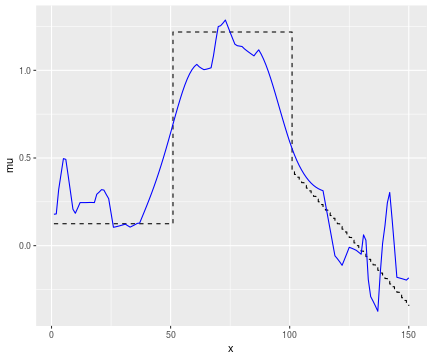

RObject{VecSxp}


In [43]:
nplots = 36
δ = evalpts[2] - evalpts[1]
means_enet = Float64[]
for i in 1:N
    f = devals_enet[i] .* evalpts
    μhat = δ .* (0.5f[1] + 0.5f[2] + sum(f[2:end - 1]))
    push!(means_enet, μhat)
end

m = 0.5*μ1 + 0.5*μ2
R"""
df = data.frame(x=$(1:N), y=$means_enet, mu=$m)
ggplot() +
    geom_step(data=df, aes(x=x, y=mu), linetype="dashed") +
    geom_line(data=df, aes(x=x, y=y), col="blue")
"""

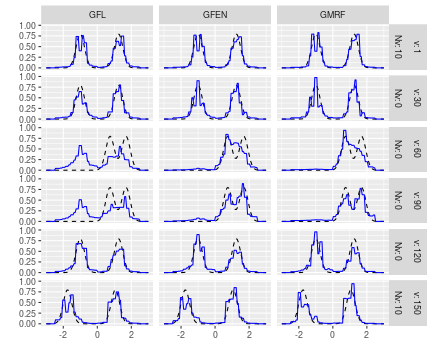

RObject{VecSxp}


In [73]:
devals_fl = results_fl["densities"]
devals_kal = results_kal["densities"]
devals_enet = results_enet["densities"]

xs = Float64[]
vals_fl = Float64[]
vals_kal = Float64[]
vals_enet = Float64[]
plt = Int[]
plt_nums = [1, 30, 60, 90, 120, 150]
for i in plt_nums
    append!(xs, evalpts)
    append!(plt, fill(i, length(evalpts)))
    append!(vals_fl, devals_fl[i])
    append!(vals_kal, devals_kal[i])
    append!(vals_enet, devals_enet[i])
end


R"""
df = data.frame(x=$xs, plt=$plt, y=$vals, linetype="dashed")
df_fl = data.frame(x=$xs, plt=$plt, y=$vals_fl, ytrue=$vals, method="GFL")
df_kal = data.frame(x=$xs, plt=$plt, y=$vals_kal, ytrue=$vals, method="GMRF")
df_enet = data.frame(x=$xs, plt=$plt, y=$vals_enet, ytrue=$vals, method="GFEN")
df_fit = rbind(df_fl, df_kal, df_enet)
df_fit$method = ordered(df_fit$method, levels=c("GFL", "GFEN", "GMRF"))
nd = $ndata
df_fit$Nv = nd[df_fit$plt]
df_fit$v = df$plt

time_labeller = function(t) {
    return (sprintf("v: %s, Nv: (%s)", t, nd[as.integer(t)]))
}
    
ggplot() +
    geom_line(data=df_fit, aes(x=x, y=ytrue), size=0.5, linetype="dashed") +
    geom_line(data=df_fit, aes(x=x, y=y), col="blue", size=0.5) +
    facet_grid(v + Nv ~ method, labeller=labeller(Nv=label_both, v=label_both)) +
    labs(x="", y="") +
    ggsave("benchmarks_densities_vertical.png", units="cm", width=15, height=15)
"""